Code for Visual Translation

Please cite us if you use this in any of your research

[Project Page](https://https://vl2g.github.io/projects/visTrans/)

Upload the following files to /content



1.   Source Image File
2.   Noto_Sans_Devanagri.zip downloaded from this [link](https://https://fonts.google.com/noto/specimen/Noto+Sans+Devanagari)
3.   A standard gray background file available [here](https://drive.google.com/file/d/1H0Qon1nnms4Ty9p2eIQ76tlhzqRM2k6v/view?usp=drive_link)
4.   Model checkpoints eng-hin.model and/or hin-eng.model(based on requirement) available [here](https://drive.google.com/drive/folders/1jPX0sjwunrjCmeCUqPd3OZ_Ur78y7d3Y?usp=drive_link)








# Setups and Installations


In [ ]:
import re
import numpy as np
import json
from scipy.interpolate import CubicSpline, interp1d
import numpy as np
import pandas as pd
import os
import cv2
from tqdm import tqdm
import json
from PIL import Image

import torch
from PIL import Image, ImageDraw
import math
import os
from skimage import io
import glob
import torch
from torch.utils.data import Dataset
import cv2

import os

import matplotlib.pyplot as plt
import numpy as np



**Make sure to restart session after each installation**

## Setting up Imagemagick

In [ ]:
%%capture
!sudo apt update
!sudo apt install libpango1.0-dev libcairo2-dev imagemagick



In [ ]:
!convert --version

Version: ImageMagick 6.9.11-60 Q16 x86_64 2021-01-25 https://imagemagick.org
Copyright: (C) 1999-2021 ImageMagick Studio LLC
License: https://imagemagick.org/script/license.php
Features: Cipher DPC Modules OpenMP(4.5) 
Delegates (built-in): bzlib djvu fftw fontconfig freetype heic jbig jng jp2 jpeg lcms lqr ltdl lzma openexr pangocairo png tiff webp wmf x xml zlib


In [ ]:
#Upload Noto_Sans_Devanangri.zip from https://fonts.google.com/noto/specimen/Noto+Sans+Devanagari to /content
%%capture
!unzip /content/Noto_Sans_Devanagari.zip

In [ ]:
!mv static/NotoSansDevanagari-Regular.ttf  /usr/share/fonts/truetype/

## Setting up IndicTransv2

In [ ]:

%%capture
!git clone https://github.com/AI4Bharat/IndicTrans2.git


In [ ]:
%%capture
%cd /content/IndicTrans2/huggingface_interface


In [ ]:
%%capture
!python3 -m pip install nltk sacremoses pandas regex mock transformers>=4.33.2 mosestokenizer
!python3 -c "import nltk; nltk.download('punkt')"
!python3 -m pip install bitsandbytes scipy accelerate datasets
!python3 -m pip install sentencepiece

!git clone https://github.com/VarunGumma/IndicTransTokenizer
%cd IndicTransTokenizer
!python3 -m pip install --editable ./
%cd ..

In [ ]:
os.chdir("/content/")

## Setting up Scene text eraser

In [ ]:
%%capture
!git clone https://github.com/Onkarsus13/Diff_SceneTextEraser




In [ ]:
%%capture
os.chdir("/content/Diff_SceneTextEraser")
!pip install -e ".[torch]"
!pip install -e .[all,dev,notebooks]
!pip install "jax[cuda12_pip]==0.4.23" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

os.chdir("/content/")


Restart session after this cell ,and rerun the imports


# Utility functions

In [ ]:
def exclude(s):
    tlds = (
          "com", "org", "net", "int", "edu", "gov", "mil", "info", "biz", "name", "museum", "coop", "aero", "xxx", "idv"
    )
    if re.fullmatch(r'\d+(\.\d+)?', s):
        return True
    if s.startswith("www.") or re.fullmatch(r'(https?://)?(?:[-\w.]|(?:%[\da-fA-F]{2}))+(\.(?:' + '|'.join(tlds) + '))', s):
        return True
    return bool(re.fullmatch(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', s))



def filter_non_translation_words(image_dict):


  final_data = {k: v for k, v in image_dict.items() if not exclude(v["txt"])}

  return final_data


In [ ]:
def detect_paragraphs(data,alpha1=0.2,alpha2=0.7,beta1= 0.4):
  """
  This function processes image img_word_crops, groups them into paragraphs and lines, and outputs the paragraph and line information to a JSON file.

  The function takes in several command-line arguments to control the clustering parameters:
  - `--a1`: Vertical distance threshold for paragraph clustering (default 0.2)
  - `--a2`: Horizontal distance threshold for paragraph clustering (default 0.7)
  - `--b1`: Vertical distance threshold for line clustering (default 0.4)
  - `--file`: Path to the input JSON file containing the image word_crop information

  The function reads in the image word_crop information from the input JSON file, performs clustering and grouping based on spatial relationships, and stores the resulting paragraph and line information in the `patch_info` dictionary. The `patch_info` dictionary is then written to a new JSON file named `para_info.json`.
  """


  beta1 = round(beta1, 1)
  word_crops = list(data.keys())
  for i in word_crops:
    data[i]["x1"], data[i]["y1"], data[i]["x2"], data[i]["y2"] = data[i]["bbox"]
    data[i]["xc"] = (data[i]["x1"] + data[i]["x2"]) / 2
    data[i]["yc"] = (data[i]["y1"] + data[i]["y2"]) / 2
    data[i]["w"] = data[i]["x2"] - data[i]["x1"]
    data[i]["h"] = data[i]["y2"] - data[i]["y1"]

  patch_info = {}
  while word_crops:
      img_name = word_crops[0].split("_")[0]
      word_crop_collection = [
          word_crop for word_crop in word_crops if word_crop.startswith(img_name)
      ]
      centroids = {}
      lines = []
      img_word_crops = word_crop_collection.copy()
      para = []
      while img_word_crops:
          clusters = []
          para_words_group = [
              img_word_crops[0],
          ]
          added = [
              img_word_crops[0],
          ]
          img_word_crops.remove(img_word_crops[0])
          ## determining the paragraph
          while added:
              word_crop = added.pop()
              for i in range(len(img_word_crops)):
                  word_crop_ = img_word_crops[i]
                  if (
                      abs(data[word_crop_]["yc"] - data[word_crop]["yc"])
                      < data[word_crop]["h"] * alpha1
                  ):
                      if data[word_crop]["xc"] > data[word_crop_]["xc"]:
                          if (data[word_crop]["x1"] - data[word_crop_]["x2"]) < data[
                              word_crop
                          ]["h"] * alpha2:
                              para_words_group.append(word_crop_)
                              added.append(word_crop_)
                      else:
                          if (data[word_crop_]["x1"] - data[word_crop]["x2"]) < data[
                              word_crop
                          ]["h"] * alpha2:
                              para_words_group.append(word_crop_)
                              added.append(word_crop_)
                  else:
                      if data[word_crop]["yc"] > data[word_crop_]["yc"]:
                          if (data[word_crop]["y1"] - data[word_crop_]["y2"]) < data[
                              word_crop
                          ]["h"] * beta1 and (
                              (
                                  (data[word_crop_]["x1"] < data[word_crop]["x2"])
                                  and (data[word_crop_]["x1"] > data[word_crop]["x1"])
                              )
                              or (
                                  (data[word_crop_]["x2"] < data[word_crop]["x2"])
                                  and (data[word_crop_]["x2"] > data[word_crop]["x1"])
                              )
                              or (
                                  (data[word_crop]["x1"] > data[word_crop_]["x1"])
                                  and (data[word_crop]["x2"] < data[word_crop_]["x2"])
                              )
                          ):
                              para_words_group.append(word_crop_)
                              added.append(word_crop_)
                      else:
                          if (data[word_crop_]["y1"] - data[word_crop]["y2"]) < data[
                              word_crop
                          ]["h"] * beta1 and (
                              (
                                  (data[word_crop_]["x1"] < data[word_crop]["x2"])
                                  and (data[word_crop_]["x1"] > data[word_crop]["x1"])
                              )
                              or (
                                  (data[word_crop_]["x2"] < data[word_crop]["x2"])
                                  and (data[word_crop_]["x2"] > data[word_crop]["x1"])
                              )
                              or (
                                  (data[word_crop]["x1"] > data[word_crop_]["x1"])
                                  and (data[word_crop]["x2"] < data[word_crop_]["x2"])
                              )
                          ):
                              para_words_group.append(word_crop_)
                              added.append(word_crop_)
              img_word_crops = [p for p in img_word_crops if p not in para_words_group]
          ## processing for the line
          while para_words_group:
              line_words_group = [
                  para_words_group[0],
              ]
              added = [
                  para_words_group[0],
              ]
              para_words_group.remove(para_words_group[0])
              ## determining the line
              while added:
                  word_crop = added.pop()
                  for i in range(len(para_words_group)):
                      word_crop_ = para_words_group[i]
                      if (
                          abs(data[word_crop_]["yc"] - data[word_crop]["yc"])
                          < data[word_crop]["h"] * alpha1
                      ):
                          if data[word_crop]["xc"] > data[word_crop_]["xc"]:
                              if (data[word_crop]["x1"] - data[word_crop_]["x2"]) < data[
                                  word_crop
                              ]["h"] * alpha2:
                                  line_words_group.append(word_crop_)
                                  added.append(word_crop_)
                          else:
                              if (data[word_crop_]["x1"] - data[word_crop]["x2"]) < data[
                                  word_crop
                              ]["h"] * alpha2:
                                  line_words_group.append(word_crop_)
                                  added.append(word_crop_)
                  para_words_group = [
                      p for p in para_words_group if p not in line_words_group
                  ]
              xc = [data[word_crop]["xc"] for word_crop in line_words_group]
              idxs = np.argsort(xc)
              patch_cluster_ = [line_words_group[i] for i in idxs]
              line_words_group = patch_cluster_
              x1 = [data[word_crop]["x1"] for word_crop in line_words_group]
              x2 = [data[word_crop]["x2"] for word_crop in line_words_group]
              y1 = [data[word_crop]["y1"] for word_crop in line_words_group]
              y2 = [data[word_crop]["y2"] for word_crop in line_words_group]
              txt_line = [data[word_crop]["txt"] for word_crop in line_words_group]
              txt = " ".join(txt_line)
              x = [x1[0]]
              y1_ = [y1[0]]
              y2_ = [y2[0]]
              l = [len(txt_l) for txt_l in txt_line]
              for i in range(1, len(x1)):
                  x.append((x1[i] + x2[i - 1]) / 2)
                  y1_.append((y1[i] + y1[i - 1]) / 2)
                  y2_.append((y2[i] + y2[i - 1]) / 2)
              x.append(x2[-1])
              y1_.append(y1[-1])
              y2_.append(y2[-1])
              line_info = {
                  "x": x,
                  "y1": y1_,
                  "y2": y2_,
                  "l": l,
                  "txt": txt,
                  "word_crops": line_words_group,
              }
              clusters.append(line_info)
          y_ = [clusters[i]["y1"][0] for i in range(len(clusters))]
          idxs = np.argsort(y_)
          clusters_ = [clusters[i] for i in idxs]
          txt = [clusters[i]["txt"] for i in idxs]
          l = [len(t) for t in txt]
          txt = " ".join(txt)
          para_info = {"lines": clusters_, "l": l, "txt": txt}
          para.append(para_info)

      for word_crop in word_crop_collection:
          word_crops.remove(word_crop)
      patch_info[img_name] = {"para": para}
  return patch_info



In [ ]:
import os

def translate(image_dict,eng_to_hin):
  os.chdir("/content/IndicTrans2/huggingface_interface/IndicTransTokenizer")
  from IndicTransTokenizer import IndicProcessor, IndicTransTokenizer
  from tqdm import tqdm
  from transformers import (
      AutoModelForSeq2SeqLM,
      AutoTokenizer,
      M2M100ForConditionalGeneration,
      M2M100Tokenizer,
  )
  DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
  if eng_to_hin:
    model_name = "ai4bharat/indictrans2-en-indic-1B"
  else:
    model_name = "ai4bharat/indictrans2-indic-en-1B"
  tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

  model = AutoModelForSeq2SeqLM.from_pretrained(model_name, trust_remote_code=True)

  ip = IndicProcessor(inference=True)
  model = model.to(DEVICE)

  # Set the source and target languages
  if eng_to_hin:
    src_lang, tgt_lang = "eng_Latn", "hin_Deva"
  else:
    src_lang, tgt_lang = "hin_Deva", "eng_Latn"

  img2info = image_dict

  # Translate each para in the list
  for img_id in tqdm(img2info.keys()):
    img_info = img2info[img_id]

    for i in range(len(img_info['para'])):
      word = img_info['para'][i]['txt']

      # Set the source language
      tokenizer.src_lang = src_lang

      batch = ip.preprocess_batch(
        [word],
          src_lang=src_lang,
          tgt_lang=tgt_lang,
      )

      # Tokenize and encode the source text
      inputs = tokenizer(
          batch,
          truncation=True,
          padding="longest",
          return_tensors="pt",
          return_attention_mask=True,
      ).to(DEVICE)

      # Generate translations
      with torch.no_grad():
          generated_tokens = model.generate(
        **inputs,
        use_cache=True,
        min_length=0,
        max_length=256,
        num_beams=5,
        num_return_sequences=1,
          )

      # Decode the generated tokens into text
      with tokenizer.as_target_tokenizer():
          generated_tokens = tokenizer.batch_decode(
        generated_tokens.detach().cpu().tolist(),
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True,
          )

      # Postprocess the translations, including entity replacement
      translation = ip.postprocess_batch(generated_tokens, lang=tgt_lang)[0]
      img2info[img_id]['para'][i]['trans_txt'] = translation
      os.chdir("/content")
  return img2info


In [ ]:
def form_word_crops(image_dict):
  '''
  Get the source word crop details (for input to STE module)
  Note that the content of the crop is irrelevant, only the style matters
  We also mantain a ratio of source and target word lenghts and accordingly reduplicate or crop the source image
  '''
  data = image_dict
  i_s = {}

  img_ids = data.keys()
  for img_id in img_ids:
      k = 0
      for p in range(len(data[img_id]["para"])):
          para_info = data[img_id]["para"][p]
          para_words = para_info['trans_txt'].split()
          para_l = [len(t) for t in para_words]
          para_l = np.cumsum(para_l)/np.sum(para_l)
          trans_words_list = []
          p_l_ = para_info['l']
          p_l_ = np.cumsum(p_l_)/np.sum(p_l_)
          loop_trans_words = []
          j = 0
          i = 0
          while i < len(para_words):
              if para_l[i] > p_l_[j]:
                  trans_words_list.append(loop_trans_words)
                  loop_trans_words = []
                  j += 1
              else:
                  loop_trans_words.append(para_words[i])
                  i += 1
          trans_words_list.append(loop_trans_words)
          for l in range(len(para_info["lines"])):
              line_info = para_info["lines"][l]
              l_ = line_info['l']
              l_ = np.cumsum(l_)/np.sum(l_)
              l_ = np.hstack([0, l_])
              xcs = CubicSpline(l_, line_info['x'])
              y1cs = CubicSpline(l_, line_info['y1'])
              y2cs = CubicSpline(l_, line_info['y2'])
              trans_words = trans_words_list[l]
              trans_l_ = [len(t) for t in trans_words]
              trans_l = np.cumsum(trans_l_)/np.sum(trans_l_)
              trans_l = np.hstack([0, trans_l])
              new_x = xcs(trans_l)
              new_y1 = y1cs(trans_l)
              new_y2 = y2cs(trans_l)
              ref_list = line_info['word_crops']
              ref_list = list(pd.cut(trans_l[1:], l_, labels=ref_list))
              ref_l = list(pd.cut(trans_l[1:], l_, labels=para_info["lines"][l]["l"],ordered=False))
              for i in range(len(trans_words)):
                  i_s[f"{img_id}_{k}"] = {
                      "ref_i_s": ref_list[i],
                      "bbox": [
                          int(new_x[i]),
                          int(new_y1[i]),
                          int(new_x[i+1]),
                          int(new_y2[i+1]),
                      ],
                      "trans_txt": trans_words[i],
                      "ratio": ref_l[i]/trans_l_[i],
                  }
                  k += 1
  return i_s

In [ ]:
def generate_and_save_word_crops(bounding_boxes,para_info,dir):

  i_s_info = bounding_boxes



  os.makedirs("tmp/i_s", exist_ok=True)

  img_ids = para_info.keys()
  for img_id in tqdm(img_ids):
      try:
          ref_id = para_info[img_id]['ref_i_s']
          x1, y1, x2, y2 = i_s_info[ref_id]['bbox']
          x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
          img_name = ref_id.split("_")[0]
          img = cv2.imread(os.path.join(dir,img_name+".jpg"))
          img = img[y1:y2, x1:x2]
          cv2.imwrite(os.path.join("tmp/i_s", f"{img_id}.png"), img)
      except:
          print(f"Error in {img_id}")

  print("crops created.")


In [ ]:
def modify_crops(para_info):
  '''
  If the target text is longer than source text ,reduplicate it
  If it is smaller, crop it
  '''
  for k, v in tqdm(para_info.items()):
      try:
          img = Image.open(f"tmp/i_s/{k}.png")
          w, h = img.size
          new_w = w/v['ratio']
          new_img = Image.new("RGB", (int(new_w), int(h)))
          for i in range(np.ceil(1/v['ratio']).astype(int)):
              new_img.paste(img, (int(i*w), 0))
          new_img.save(f"tmp/i_s/{k}.png")
      except:
          print(f"Error in {k}")

  print("crops transformed.")

In [ ]:
def run_string_as_bash(command):

  if "b'" in str(command):
    with open('script.sh','w') as f:
      f.write(command.decode())
  else:
    with open('script.sh','w') as f:
      f.write(command)
  !bash script.sh

In [ ]:
def generate_i_t(para_info,save_path = './tmp/i_t'):
  '''f
  Make the black background white text i_t images needed for generation
  '''

  labels = para_info

  temp_save_path = f'{save_path}_temp'
  os.makedirs(save_path, exist_ok=True)
  os.makedirs(temp_save_path, exist_ok=True)

  text_image_size = '256x100'
  image_size = '256x128'

  gray_bg_path = '/content/gray_bg_256x128.png' #upload gray colored image to this path
  font_name = 'Noto Sans'

  for crop_name, label in tqdm(labels.items()):

      label = label['trans_txt']

      save_file_path = os.path.join(save_path, f'{crop_name}.png')
      temp_save_file_path = os.path.join(temp_save_path, f'{crop_name}.png')

      input_text_command = f'convert -alpha set -background "rgb(121,127,141)" pango:\'  \
                          <span font_stretch="semicondensed" foreground="#000000" font=" {font_name} 30 ">{label}</span> \
                          \' \png:-|convert -  \\( +clone \\) +swap  -background "rgb(121,127,141)" -layers merge  +repage png:-|\
                          convert -   -trim +repage -resize {text_image_size} {temp_save_file_path}'

      run_string_as_bash(input_text_command.encode('utf-8'))

      finalInputTextCommand = 'composite -gravity Center ' + f'{temp_save_file_path}' + ' ' + gray_bg_path
      finalInputTextCommand += ' png:-|'
      finalInputTextCommand += 'convert -  ' + save_file_path
      run_string_as_bash(finalInputTextCommand.encode('utf-8'))
  run_string_as_bash(f'rm -rf {temp_save_path}')


In [ ]:
## Scene text eraser

In [ ]:
def create_masks(img_path,para_info,mask_path):
  '''
  Make masks (black images with white-filled bounding boxes)
  required for scene text eraser
  '''
  img = Image.open(img_path)
  mask = Image.new('L', (img.size[0], img.size[1]), 0)
  draw = ImageDraw.Draw(mask)
  for key in para_info:

    draw.rectangle(para_info[key]['bbox'],fill=255)

  mask.save(mask_path)

In [ ]:
def erase_text(INPUT_IMAGE_PATH,MASK_IMAGE_PATH,SAVE_IMAGE_PATH):
  os.chdir("/content/Diff_SceneTextEraser")

  from diffusers import (
    EulerAncestralDiscreteScheduler,
    StableDiffusionControlNetSceneTextErasingPipeline,
    )

  model_path = "onkarsus13/controlnet_stablediffusion_scenetextEraser"


  pipe = StableDiffusionControlNetSceneTextErasingPipeline.from_pretrained(model_path)



  # ----------------------------------------------


  device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')



  pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

  pipe.to(device)

  # pipe.enable_xformers_memory_efficient_attention()
  #pipe.enable_model_cpu_offload()

  generator = torch.Generator(device).manual_seed(1)

  image = Image.open(INPUT_IMAGE_PATH)
  mask_image = Image.open(MASK_IMAGE_PATH)

  original_image_size = image.size
  new_image_size = (512, 512)

  image = image.resize(new_image_size)
  mask_image = mask_image.resize(new_image_size)

  result_image = pipe(
      image,
      mask_image,
      [mask_image],
      num_inference_steps=20,
      generator=generator,
      controlnet_conditioning_scale=1.0,
      guidance_scale=1.0
  ).images[0]

  result_image = result_image.resize(original_image_size)
  result_image.save(SAVE_IMAGE_PATH)


  os.chdir("/content")


In [ ]:
def make_output_base(img_path,eraser_output_path,base_path,i_s_info):
  '''
  We may use the output of scene text erased image as text background
  But for more perfection , we keep the non text pixels (region outside
  the bounding boxes ) same as input image , and use the diffusion based
  scene text eraser output only in the bounding box regions (by cropping and
  pasting)
  '''
  os.makedirs(base_path,exist_ok = True)
  base_img_path = os.path.join(base_path,img_path.split("/")[-1])
  run_string_as_bash(f"cp {img_path} {base_img_path} " )
  for img_id in i_s_info.keys():
    img_name = img_id.split("_")[0]
    img = Image.open(base_img_path)
    bg = Image.open(eraser_output_path)
    bg = bg.crop(i_s_info[img_id]['bbox'])
    img.paste(bg, (int(i_s_info[img_id]['bbox'][0]), int(i_s_info[img_id]['bbox'][1])))
    img.save(base_img_path)





In [ ]:
def make_bg(i_s_info,base_path,bg_crop_path):
  '''
  cropped backgrounds
  '''
  os.makedirs(bg_crop_path,exist_ok = True)
  for img_id in i_s_info.keys():

    os.makedirs(bg_crop_path,exist_ok = True)
    x1, y1, x2, y2 = i_s_info[img_id]['bbox']
    img = cv2.imread(base_path)
    img_bg = img[y1:y2,x1:x2]

    cv2.imwrite(os.path.join(bg_crop_path,img_id)+".png",img_bg)


In [ ]:
#Important definitions for VTNet/SRNet++ architecture
import torch
from torchvision.models import vgg19

temp_shape = (0,0)

def calc_padding(h, w, k, s):

    h_pad = (((h-1)*s) + k - h)//2
    w_pad = (((w-1)*s) + k - w)//2

    return (h_pad, w_pad)

def calc_inv_padding(h, w, k, s):
    h_pad = (k-h + ((h-1)*s))//2
    w_pad = (k-w + ((w-1)*s))//2

    return (h_pad, w_pad)


class Conv_bn_block(torch.nn.Module):

    def __init__(self, *args, **kwargs):
        super().__init__()

        self._conv = torch.nn.Conv2d(*args, **kwargs)
        self._bn = torch.nn.BatchNorm2d(kwargs['out_channels'])

    def forward(self, input):
        return torch.nn.functional.leaky_relu(self._bn(self._conv(input)),negative_slope=0.2)

class Res_block(torch.nn.Module):

    def __init__(self, in_channels):
        super().__init__()

        self._conv1 = torch.nn.Conv2d(in_channels, in_channels//4, kernel_size = 1, stride =1)
        self._conv2 = torch.nn.Conv2d(in_channels//4, in_channels//4, kernel_size = 3, stride = 1, padding = 1)

        self._conv3 = torch.nn.Conv2d(in_channels//4, in_channels, kernel_size = 1, stride=1)

        self._bn = torch.nn.BatchNorm2d(in_channels)

    def forward(self, x):

        xin = x
        x = torch.nn.functional.leaky_relu(self._conv1(x),negative_slope=0.2)
        x = torch.nn.functional.leaky_relu(self._conv2(x),negative_slope=0.2)
        x = self._conv3(x)
        x = torch.add(xin, x)
        x = torch.nn.functional.leaky_relu(self._bn(x),negative_slope=0.2)

        return x

class encoder_net(torch.nn.Module):

    def __init__(self, in_channels, get_feature_map = False):
        super().__init__()

        self.cnum = 32
        self.get_feature_map = get_feature_map
        self._conv1_1 = Conv_bn_block(in_channels = in_channels, out_channels = self.cnum, kernel_size = 3, stride = 1, padding = 1)

        self._conv1_2 = Conv_bn_block(in_channels =self.cnum, out_channels = self.cnum, kernel_size = 3, stride = 1, padding = 1)

        #--------------------------

        self._pool1 = torch.nn.Conv2d(in_channels = self.cnum, out_channels = 2 * self.cnum, kernel_size = 3, stride = 2, padding = calc_padding(temp_shape[0], temp_shape[1], 3, 2))

        self._conv2_1 = Conv_bn_block(in_channels = 2* self.cnum, out_channels = 2*self.cnum, kernel_size = 3, stride = 1, padding = 1)

        self._conv2_2 = Conv_bn_block(in_channels = 2* self.cnum, out_channels = 2*self.cnum, kernel_size = 3, stride = 1, padding = 1)

        #---------------------------

        self._pool2 = torch.nn.Conv2d(in_channels = 2*self.cnum, out_channels = 4* self.cnum, kernel_size = 3, stride = 2, padding = calc_padding(temp_shape[0], temp_shape[1], 3, 2))

        self._conv3_1 = Conv_bn_block(in_channels = 4* self.cnum, out_channels = 4*self.cnum, kernel_size = 3, stride = 1, padding = 1)

        self._conv3_2 = Conv_bn_block(in_channels = 4* self.cnum, out_channels = 4*self.cnum, kernel_size = 3, stride = 1, padding = 1)

        #---------------------------

        self._pool3 = torch.nn.Conv2d(in_channels = 4*self.cnum, out_channels = 8* self.cnum, kernel_size = 3, stride = 2, padding = calc_padding(temp_shape[0], temp_shape[1], 3, 2))

        self._conv4_1 = Conv_bn_block(in_channels = 8* self.cnum, out_channels = 8*self.cnum, kernel_size = 3, stride = 1, padding = 1)

        self._conv4_2 = Conv_bn_block(in_channels = 8* self.cnum, out_channels = 8*self.cnum, kernel_size = 3, stride = 1, padding = 1)

    def forward(self, x):

        x = self._conv1_1(x)
        x = self._conv1_2(x)

        x = torch.nn.functional.leaky_relu(self._pool1(x),negative_slope=0.2)
        x = self._conv2_1(x)
        x = self._conv2_2(x)

        f1 = x

        x = torch.nn.functional.leaky_relu(self._pool2(x),negative_slope=0.2)
        x = self._conv3_1(x)
        x = self._conv3_2(x)

        f2 = x

        x = torch.nn.functional.leaky_relu(self._pool3(x),negative_slope=0.2)
        x = self._conv4_1(x)
        x = self._conv4_2(x)


        if self.get_feature_map:
            return x, [f2, f1]

        else:
            return x


class build_res_block(torch.nn.Module):

    def __init__(self, in_channels):

        super().__init__()

        self._block1 = Res_block(in_channels)
        self._block2 = Res_block(in_channels)
        self._block3 = Res_block(in_channels)
        self._block4 = Res_block(in_channels)

    def forward(self, x):

        x = self._block1(x)
        x = self._block2(x)
        x = self._block3(x)
        x = self._block4(x)

        return x


class decoder_net(torch.nn.Module):

    def __init__(self, in_channels, get_feature_map = False, mt =1, fn_mt=1):
        super().__init__()

        self.cnum = 32

        self.get_feature_map = get_feature_map

        self._conv1_1 = Conv_bn_block(in_channels = fn_mt*in_channels , out_channels = 8*self.cnum, kernel_size = 3, stride =1, padding = 1)

        self._conv1_2 = Conv_bn_block(in_channels = 8*self.cnum, out_channels = 8*self.cnum, kernel_size = 3, stride =1, padding = 1)

        #-----------------

        self._deconv1 = torch.nn.ConvTranspose2d(8*self.cnum, 4*self.cnum, kernel_size = 3, stride = 2, padding = calc_inv_padding(temp_shape[0], temp_shape[1], 3, 2))

        self._conv2_1 = Conv_bn_block(in_channels = fn_mt*mt*4*self.cnum, out_channels = 4*self.cnum, kernel_size = 3, stride = 1, padding = 1)

        self._conv2_2 = Conv_bn_block(in_channels = 4*self.cnum, out_channels = 4*self.cnum, kernel_size = 3, stride = 1, padding = 1)

        #-----------------

        self._deconv2 = torch.nn.ConvTranspose2d(4*self.cnum, 2*self.cnum, kernel_size =3 , stride = 2, padding = calc_inv_padding(temp_shape[0], temp_shape[1], 3, 2))

        self._conv3_1 = Conv_bn_block(in_channels = fn_mt*mt*2*self.cnum, out_channels = 2*self.cnum, kernel_size = 3, stride = 1, padding = 1)

        self._conv3_2 = Conv_bn_block(in_channels = 2*self.cnum, out_channels = 2*self.cnum, kernel_size = 3, stride = 1, padding = 1)

        #----------------

        self._deconv3 = torch.nn.ConvTranspose2d(2*self.cnum, self.cnum, kernel_size =3 , stride = 2, padding = calc_inv_padding(temp_shape[0], temp_shape[1], 3, 2))

        self._conv4_1 = Conv_bn_block(in_channels = self.cnum, out_channels = self.cnum, kernel_size = 3, stride = 1, padding = 1)
        self._conv4_2 = Conv_bn_block(in_channels = self.cnum, out_channels = self.cnum, kernel_size = 3, stride = 1, padding = 1)


    def forward(self, x, fuse = None):


        if fuse and fuse[0] is not None:
            x = torch.cat((x, fuse[0]), dim = 1)

        x = self._conv1_1(x)
        x = self._conv1_2(x)
        f1 = x

        #----------

        x = torch.nn.functional.leaky_relu(self._deconv1(x), negative_slope=0.2)

        if fuse and fuse[1] is not None:
            x = torch.cat((x, fuse[1]), dim = 1)

        x = self._conv2_1(x)
        x = self._conv2_2(x)
        f2 = x

        #----------

        x = torch.nn.functional.leaky_relu(self._deconv2(x), negative_slope=0.2)
        if fuse and fuse[2] is not None:
            x = torch.cat((x, fuse[2]), dim = 1)

        x = self._conv3_1(x)
        x = self._conv3_2(x)
        f3 = x

        #----------

        x = torch.nn.functional.leaky_relu(self._deconv3(x), negative_slope=0.2)
        x = self._conv4_1(x)
        x = self._conv4_2(x)

        if self.get_feature_map:
            return x, [f1, f2, f3]

        else:
            return x


class text_conversion_net(torch.nn.Module):

    def __init__(self, in_channels):
        super().__init__()

        self.cnum = 32
        self._t_encoder = encoder_net(in_channels)
        self._t_res = build_res_block(8*self.cnum)

        self._s_encoder = encoder_net(in_channels)
        self._s_res = build_res_block(8*self.cnum)

        self._sk_decoder = decoder_net(16*self.cnum)
        self._sk_out = torch.nn.Conv2d(self.cnum, 1, kernel_size =3, stride = 1, padding = 1)

        self._t_decoder = decoder_net(16*self.cnum)
        self._t_cbr = Conv_bn_block(in_channels = 2*self.cnum, out_channels = 2*self.cnum, kernel_size = 3, stride = 1, padding = 1)

        self._t_out = torch.nn.Conv2d(2*self.cnum, 3, kernel_size = 3, stride = 1, padding = 1)

    def forward(self, x_t, x_s):

        x_t = self._t_encoder(x_t)
        x_t = self._t_res(x_t)

        x_s = self._s_encoder(x_s)
        x_s = self._s_res(x_s)

        x = torch.cat((x_t, x_s), dim = 1)

        y_sk = self._sk_decoder(x, fuse = None)
        y_sk_out = torch.sigmoid(self._sk_out(y_sk))

        y_t = self._t_decoder(x, fuse = None)

        y_t = torch.cat((y_sk, y_t), dim = 1)
        y_t = self._t_cbr(y_t)
        y_t_out = torch.tanh(self._t_out(y_t))

        return y_sk_out, y_t_out


class fusion_net(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.cnum = 32

        self._encoder = encoder_net(in_channels)
        self._res = build_res_block(8*self.cnum)

        self._decoder = decoder_net(8*self.cnum, fn_mt = 1)

        self._out = torch.nn.Conv2d(self.cnum, 3, kernel_size = 3, stride = 1, padding = 1)

    def forward(self, x, fuse=None):

        x = self._encoder(x)
        x = self._res(x)
        x = self._decoder(x, fuse = fuse)
        x = torch.tanh(self._out(x))

        return x

class Generator(torch.nn.Module):

    def __init__(self, in_channels):

        super().__init__()

        self.cnum = 32

        self._tcn = text_conversion_net(in_channels)

        self._fn = fusion_net(in_channels)

    def forward(self, i_t, i_s, gbl_shape):

        o_sk, o_t = self._tcn(i_t, i_s)

        o_f = self._fn(o_t)

        return o_sk, o_t, o_f


class Discriminator(torch.nn.Module):

    def __init__(self, in_channels):
        super().__init__()

        self.cnum = 32
        self._conv1 = torch.nn.Conv2d(in_channels, 64, kernel_size = 3, stride = 2, padding = calc_padding(temp_shape[0], temp_shape[1], 3, 2))
        self._conv2 = torch.nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = calc_padding(temp_shape[0], temp_shape[1], 3, 2))

        self._conv2_bn = torch.nn.BatchNorm2d(128)

        self._conv3 = torch.nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = calc_padding(temp_shape[0], temp_shape[1], 3, 2))

        self._conv3_bn = torch.nn.BatchNorm2d(256)

        self._conv4 = torch.nn.Conv2d(256, 512, kernel_size = 3, stride = 2, padding = calc_padding(temp_shape[0], temp_shape[1], 3, 2))

        self._conv4_bn = torch.nn.BatchNorm2d(512)

        self._conv5 = torch.nn.Conv2d(512, 1,  kernel_size = 3, stride = 1, padding = 1)

        self._conv5_bn = torch.nn.BatchNorm2d(1)


    def forward(self, x):

        x = torch.nn.functional.leaky_relu(self._conv1(x), negative_slope=0.2)
        x = self._conv2(x)
        x = torch.nn.functional.leaky_relu(self._conv2_bn(x), negative_slope=0.2)
        x = self._conv3(x)
        x = torch.nn.functional.leaky_relu(self._conv3_bn(x), negative_slope=0.2)
        x = self._conv4(x)
        x = torch.nn.functional.leaky_relu(self._conv4_bn(x), negative_slope=0.2)
        x = self._conv5(x)
        x = self._conv5_bn(x)

        return x


class Vgg19(torch.nn.Module):
    def __init__(self):

        super(Vgg19, self).__init__()
        features = list(vgg19(pretrained = True).features)
        self.features = torch.nn.ModuleList(features).eval()

    def forward(self, x):

        results = []
        for ii, model in enumerate(self.features):
            x = model(x)

            if ii in {1, 6, 11, 20, 29}:
                results.append(x)
        return results




In [ ]:
class To_tensor(object):
    def __call__(self, sample):

        i_t, i_s = sample

        i_t = i_t.transpose((2, 0, 1)) /127.5 -1
        i_s = i_s.transpose((2, 0, 1)) /127.5 -1

        i_t = torch.from_numpy(i_t)
        i_s = torch.from_numpy(i_s)

        return (i_t.float(), i_s.float())


In [ ]:
def infer(i_s,i_t,model,result_path):
  tmfr = To_tensor()
  i_s = io.imread(i_s)
  if len(i_s.shape) == 2 or i_s.shape[2] == 1:
      i_s = np.repeat(i_s[:, :, np.newaxis], 3, axis=2)
  else:
      i_s = i_s[:, :, :3]
  orig_i_s_size = i_s.shape
  orig_i_s_size = (orig_i_s_size[1], orig_i_s_size[0])
  i_s = cv2.resize(i_s, size)

  i_t = io.imread(i_t)
  i_t = cv2.resize(i_t, size)

  i_t, i_s = tmfr([i_t, i_s])

  i_t = i_t.unsqueeze(0).to(device)
  i_s = i_s.unsqueeze(0).to(device)

  with torch.no_grad():
    o_sk, o_t, o_f = model(i_t, i_s, (i_t.shape[2], i_t.shape[3]))

  o_f = o_f.squeeze(0).detach().to('cpu').permute(1, 2, 0).numpy()
  o_f = 127.5*o_f + 127.5
  o_f = o_f.astype('uint8')
  o_f = cv2.resize(o_f, orig_i_s_size)

  o_t = o_t.squeeze(0).detach().to('cpu').permute(1, 2, 0).numpy()
  o_t = 127.5*o_t + 127.5
  o_t = o_t.astype('uint8')
  o_t = cv2.resize(o_t, orig_i_s_size)
  o_t = cv2.cvtColor(o_t, cv2.COLOR_BGR2GRAY)
  _, o_t = cv2.threshold(o_t, 125, 255, cv2.THRESH_BINARY)

  o_sk = o_sk.squeeze(0).detach().to('cpu').permute(1, 2, 0).numpy()
  o_sk = 255.0*o_sk
  o_sk = o_sk.astype('uint8')
  o_sk = cv2.resize(o_sk, orig_i_s_size)

  plt.imsave(result_path, o_f)

In [ ]:
def blend_o_t_b_g(txt_img,bg_img):
  '''
  Blend VTNet generated foregrounds and Diffusion generated backgrounds
  '''
  h, w, _ = bg_img.shape
  txt_img = cv2.resize(txt_img, (w,h))
  gray_img = cv2.cvtColor(txt_img, cv2.COLOR_BGR2GRAY)
  _, mask = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  corner_pixel = mask[0,0]
  if corner_pixel == 255:
      mask = cv2.bitwise_not(mask)
  radius = 1

  blurred_mask = cv2.GaussianBlur(mask, (radius*2+1, radius*2+1), 0)
  blurred_mask_float = blurred_mask.astype(np.float32) / 255.0
  txt_img_float = txt_img.astype(np.float32)
  bg_img_float = bg_img.astype(np.float32)
  blurred_mask_3c = cv2.merge([blurred_mask_float, blurred_mask_float, blurred_mask_float])
  composite = (txt_img_float * blurred_mask_3c) + (bg_img_float * (1 - blurred_mask_3c))
  composite = np.uint8(composite)
  return composite



In [ ]:
def blend(o_t_path,bg_path,save_path):
  o_t_img = cv2.imread(o_t_path)
  bg_img = cv2.imread(bg_path)

  img = blend_o_t_b_g(o_t_img, bg_img)
  os.makedirs(save_path,exist_ok = True)
  save_path = os.path.join(save_path, o_t_path.split("/")[-1])

  cv2.imwrite(save_path, img)


In [ ]:
def create_final_img(i_s_info,output_crop_path,output_base_path,o_f_path):
  for img_id in i_s_info.keys():
    base_img_path = os.path.join(output_base_path,img_id.split("_")[0]+".jpg")
    img = Image.open(base_img_path)
    img_crop = Image.open(os.path.join(output_crop_path,img_id+".png"))
    x1, y1, _, _ = i_s_info[img_id]['bbox']
    img.paste(img_crop, (x1, y1))
    img.save(base_img_path)
  os.system(f"cp {base_img_path} {o_f_path}")
  img = Image.open(o_f_path)
  plt.imshow(img)

# Main code

**Make sure to get the bounding boxes using any pre- existing OCR  in the below format**

All the box id_s should be same as the image name (If image name is 208.jpg, bounding box id's should be 208_0,208_1 , etc

In [ ]:
bounding_boxes = {"208_1": {
        "txt": "mobile",
        "bbox": [
            346.01,
            213.0,
            503.99,
            273.0
        ],
        },
          "208_0": {
        "txt": "phones",
        "bbox": [
            298.31,
            265.25,
            473.69,
            330.75
        ],
          },
              "208_2": {
        "txt": "No",
        "bbox": [
            267.67,
            205.9,
            336.33,
            275.1
        ]
        },
              }

In [ ]:
#Input Image

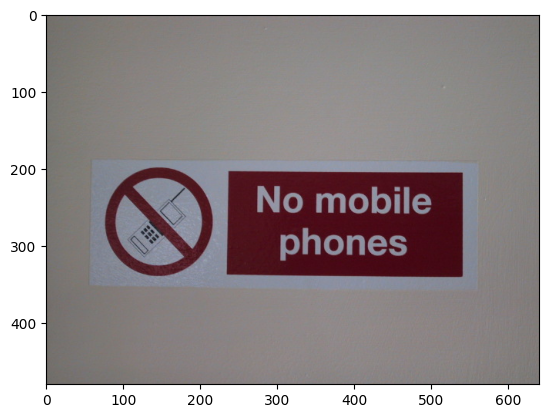

In [ ]:
img = Image.open("/content/208.jpg")
plt.imshow(img)

In [ ]:
#Getting paragraph level information from bounding boxes
eng_to_hin = True # false if hin-eng
para_info = translate(detect_paragraphs(filter_non_translation_words(bounding_boxes)),eng_to_hin)



  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


In [ ]:
para_info

{'208': {'para': [{'lines': [{'x': [267.67, 341.16999999999996, 503.99],
      'y1': [205.9, 209.45, 213.0],
      'y2': [275.1, 274.05, 273.0],
      'l': [2, 6],
      'txt': 'No mobile',
      'word_crops': ['208_2', '208_1']},
     {'x': [298.31, 473.69],
      'y1': [265.25, 265.25],
      'y2': [330.75, 330.75],
      'l': [6],
      'txt': 'phones',
      'word_crops': ['208_0']}],
    'l': [9, 6],
    'txt': 'No mobile phones',
    'trans_txt': 'मोबाइल फोन नहीं '}]}}

If you get Memory Limit exceeded at any step , you can just restart the session
All the generated files are save in tmp folder and if any function returns a json , you can just print it , restart the session and use the printed json in other calls

In [ ]:
# getting different crop level images required for STE models
para_info = form_word_crops(para_info)
generate_and_save_word_crops(bounding_boxes,para_info,"/content/")
modify_crops(para_info)
generate_i_t(para_info)

100%|██████████| 3/3 [00:00<00:00, 92.19it/s]


crops created.


100%|██████████| 3/3 [00:00<00:00, 314.93it/s]


crops transformed.


100%|██████████| 3/3 [00:00<00:00,  4.06it/s]


In [ ]:
#get text-erased background
create_masks("/content/208.jpg",para_info,mask_path = "/content/tmp/mask.png")

erase_text("/content/208.jpg", "/content/tmp/mask.png","/content/tmp/eraser_output.png")
make_output_base("/content/208.jpg","/content/tmp/eraser_output.png","/content/tmp/output_base/",para_info)
make_bg(para_info,"/content/tmp/output_base/208.jpg","/content/tmp/bg_crops")

**SRNet++ Inference**

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G = Generator(in_channels = 3).to(device)
size = (128, 64)

G.eval()
G.load_state_dict(torch.load("eng_hin.model")['generator']) # change to hin_eng for hin-to-eng



<All keys matched successfully>

In [ ]:
for img in os.listdir("./tmp/i_s"):
  i_s_path = os.path.join("./tmp/i_s",img)
  i_t_path = os.path.join("./tmp/i_t",img)
  bg_path = os.path.join("./tmp/bg_crops",img)
  os.makedirs("./tmp/foregrounds",exist_ok = True)

  infer(i_s_path,i_t_path,G,"./tmp/foregrounds/"+img)

  generated_path = os.path.join("./tmp/foregrounds/",img)
  blend(generated_path,bg_path,"./tmp/blended_crops/")

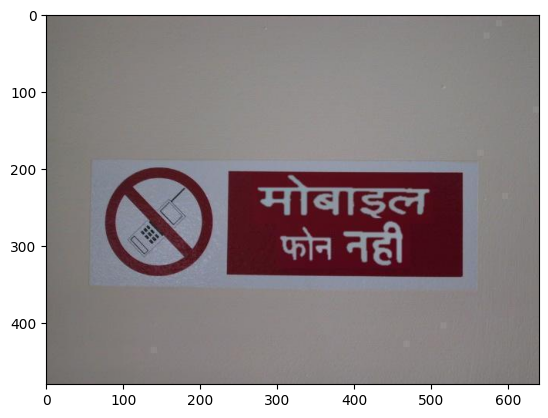

In [ ]:
create_final_img(para_info,"./tmp/blended_crops","./tmp/output_base",o_f_path = "./output_img.jpg")